Stitching images using SIFT...


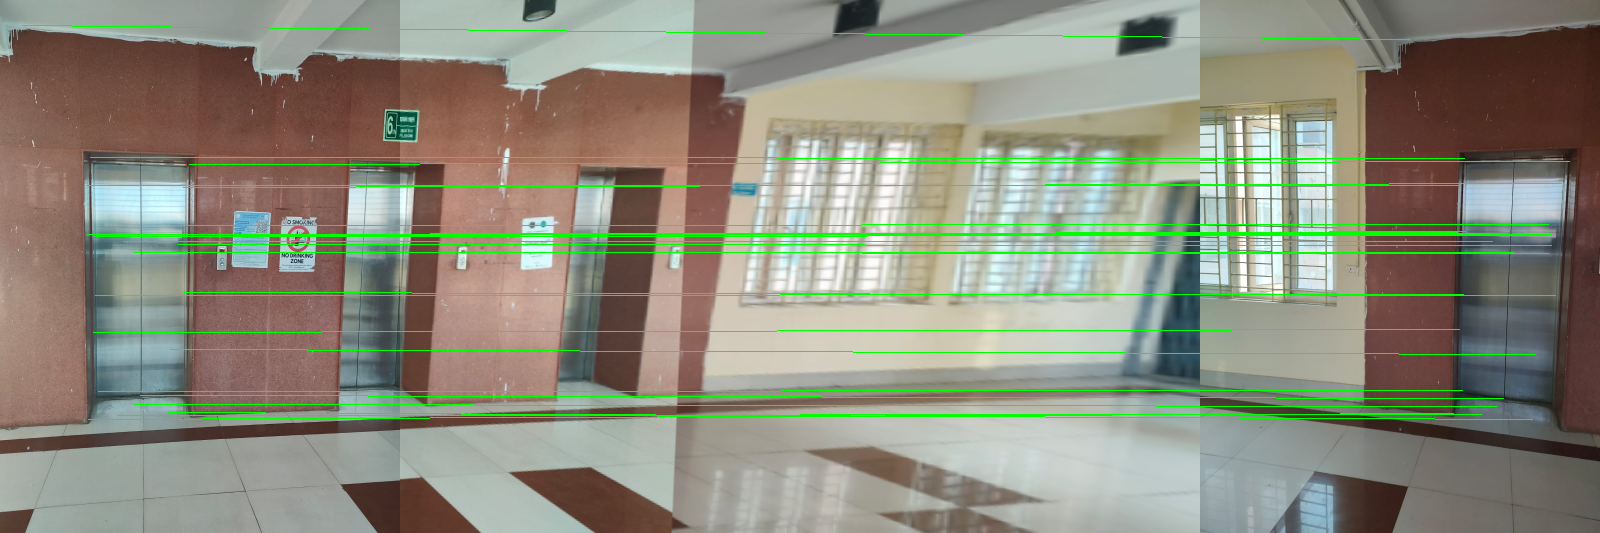

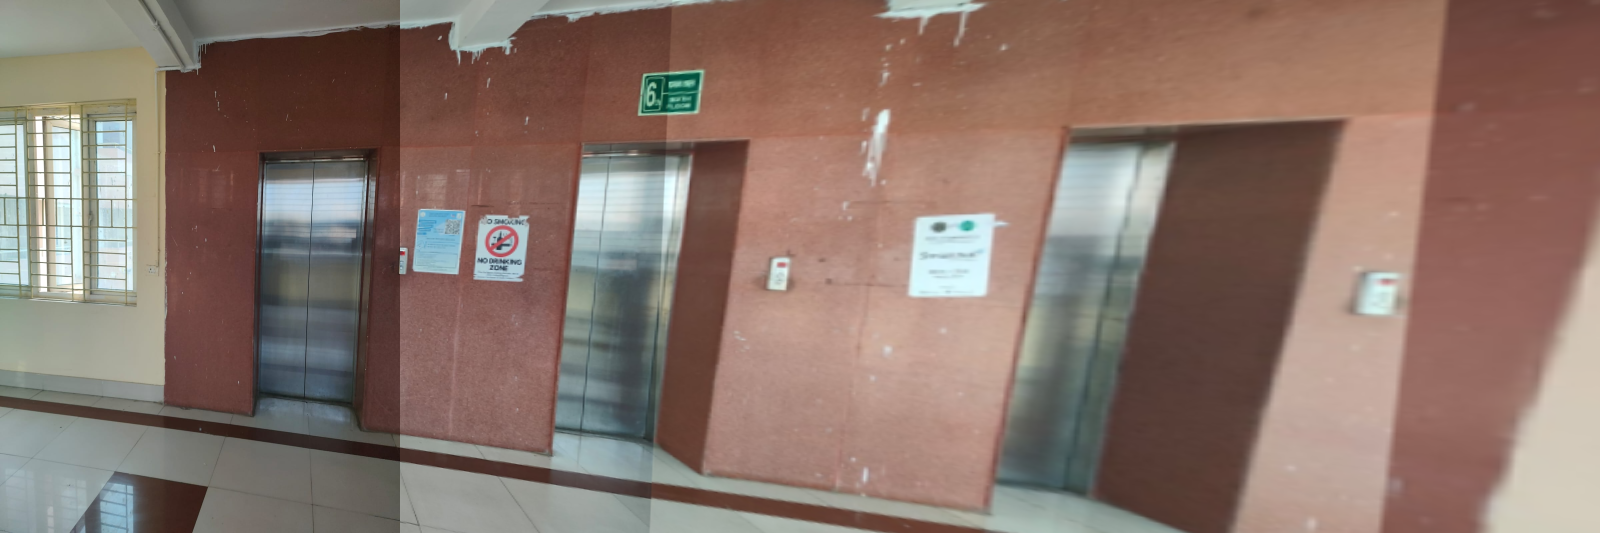

Stitching images using AKAZE...


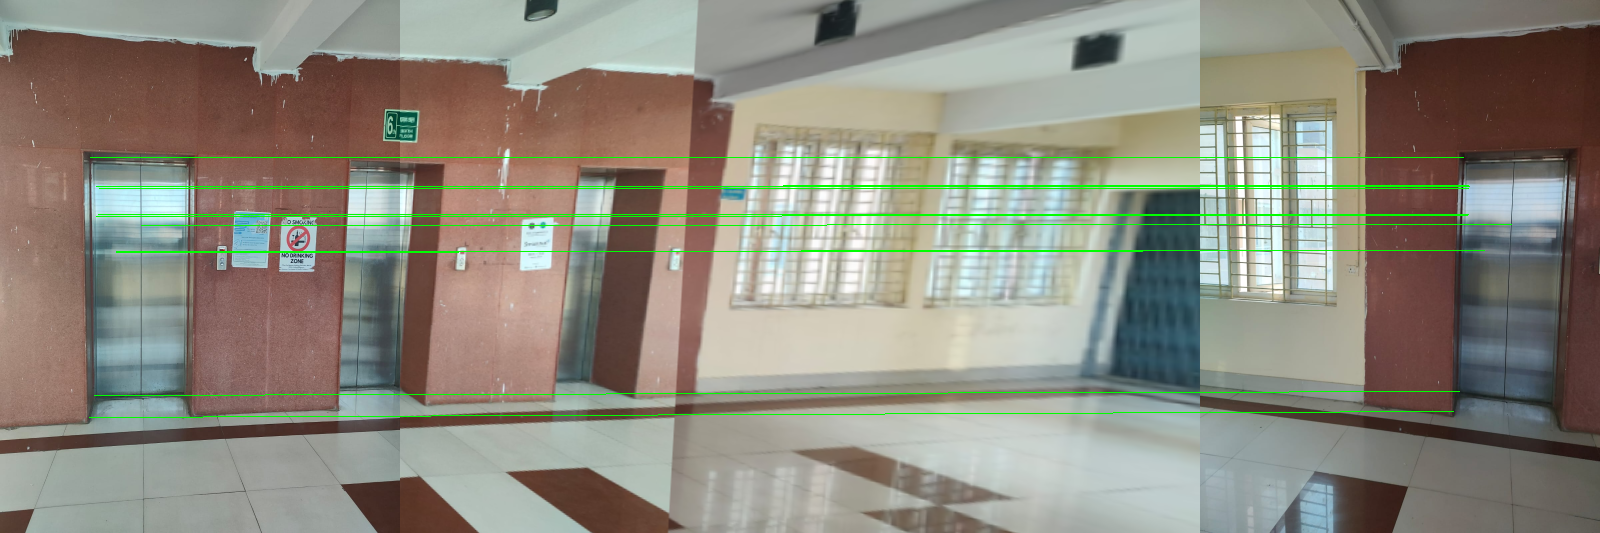

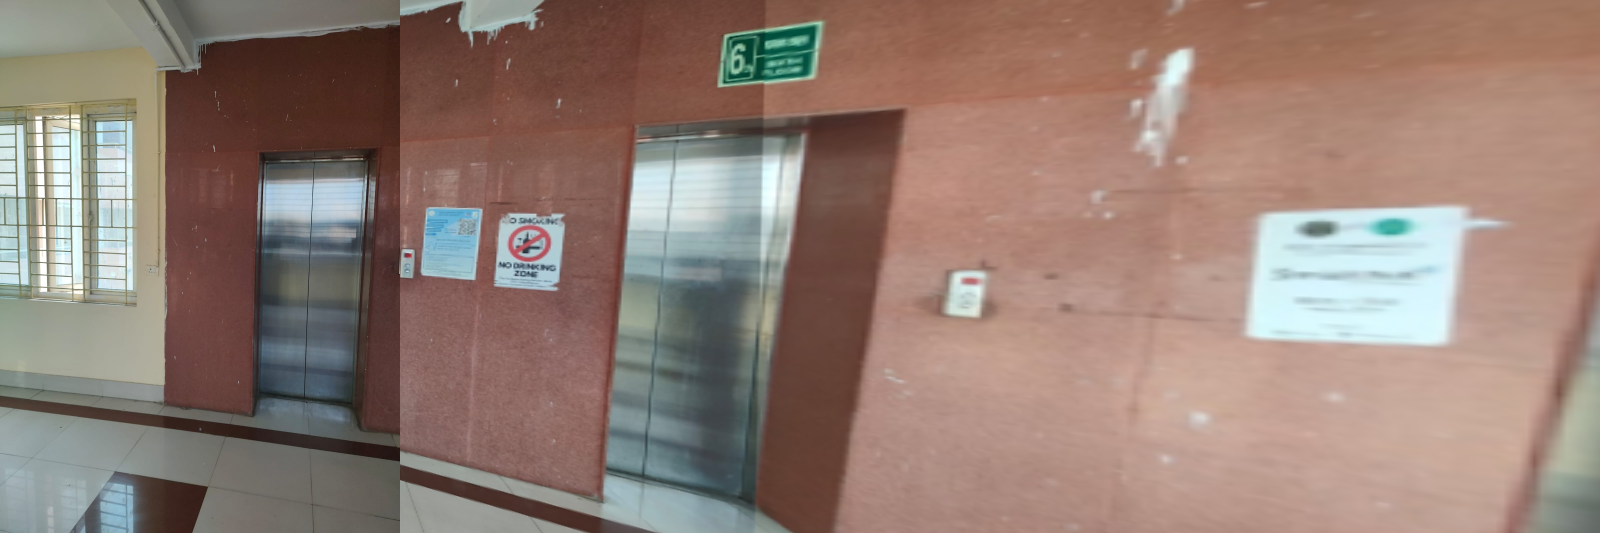

Stitching images using BRISK...


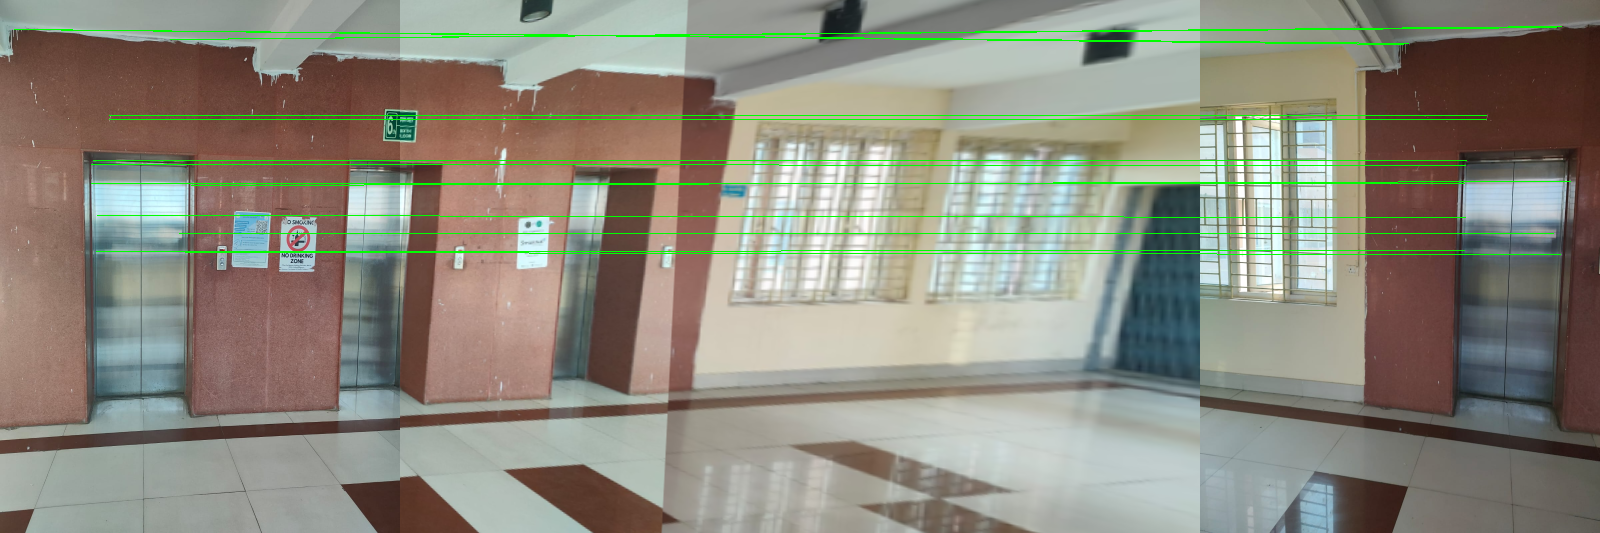

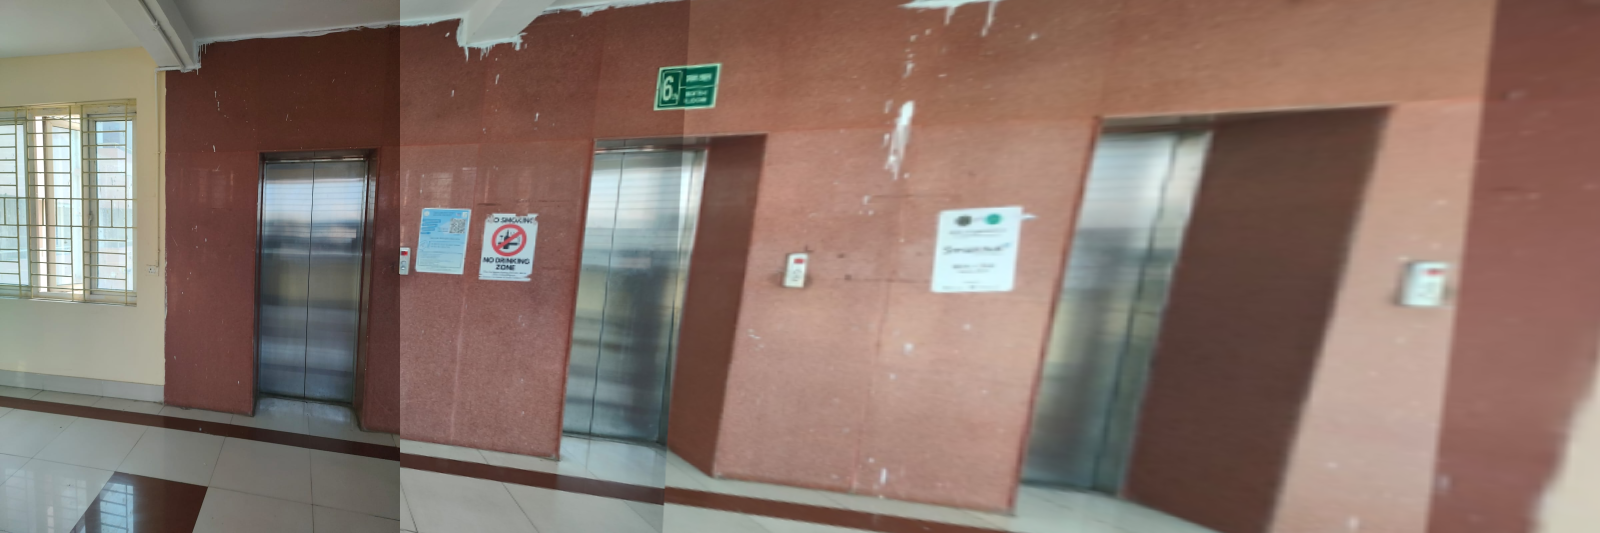

In [4]:
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow

class Panorama:
    def __init__(self, detector='SIFT'):
        self.detector = detector

    def detect_feature_and_keypoints(self, image):
        # detect and extract features from the image based on the chosen detector
        if self.detector == 'SIFT':
            descriptors = cv2.SIFT_create()
        elif self.detector == 'ORB':
            descriptors = cv2.ORB_create()
        elif self.detector == 'AKAZE':
            descriptors = cv2.AKAZE_create()
        elif self.detector == 'BRISK':
            descriptors = cv2.BRISK_create()

        (keypoints, features) = descriptors.detectAndCompute(image, None)
        keypoints = np.float32([i.pt for i in keypoints])
        return keypoints, features

    def get_all_possible_matches(self, featuresA, featuresB):
        # compute all matches using Euclidean distance
        match_instance = cv2.DescriptorMatcher_create("BruteForce")
        All_Matches = match_instance.knnMatch(featuresA, featuresB, 2)
        return All_Matches

    def get_all_valid_matches(self, AllMatches, lowe_ratio):
        # filter valid matches according to Lowe's ratio test
        valid_matches = []
        for val in AllMatches:
            if len(val) == 2 and val[0].distance < val[1].distance * lowe_ratio:
                valid_matches.append((val[0].trainIdx, val[0].queryIdx))
        return valid_matches

    def compute_homography(self, pointsA, pointsB, max_Threshold):
        return cv2.findHomography(pointsA, pointsB, cv2.RANSAC, max_Threshold)

    def match_keypoints(self, KeypointsA, KeypointsB, featuresA, featuresB, lowe_ratio, max_Threshold):
        all_matches = self.get_all_possible_matches(featuresA, featuresB)
        valid_matches = self.get_all_valid_matches(all_matches, lowe_ratio)

        if len(valid_matches) <= 4:
            return None
        # construct the two sets of points
        points_A = np.float32([KeypointsA[i] for (_, i) in valid_matches])
        points_B = np.float32([KeypointsB[i] for (i, _) in valid_matches])
        (homography, status) = self.compute_homography(points_A, points_B, max_Threshold)
        return valid_matches, homography, status

    def image_stitch(self, images, lowe_ratio=0.75, max_Threshold=4.0, match_status=False):
        (imageB, imageA) = images
        (key_points_A, features_of_A) = self.detect_feature_and_keypoints(imageA)
        (key_points_B, features_of_B) = self.detect_feature_and_keypoints(imageB)
        Values = self.match_keypoints(key_points_A, key_points_B, features_of_A, features_of_B, lowe_ratio, max_Threshold)
        if Values is None:
            return None
        (matches, homography, status) = Values
        result_image = self.get_warp_perspective(imageA, imageB, homography)
        result_image[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
        if match_status:
            vis = self.draw_matches(imageA, imageB, key_points_A, key_points_B, matches, status)
            return result_image, vis
        return result_image

    def get_warp_perspective(self, imageA, imageB, homography):
        val = imageA.shape[1] + imageB.shape[1]
        result_image = cv2.warpPerspective(imageA, homography, (val, imageA.shape[0]))
        return result_image

    def get_image_dimension(self, image):
        return image.shape[:2]

    def get_points(self, imageA, imageB):
        (hA, wA) = self.get_image_dimension(imageA)
        (hB, wB) = self.get_image_dimension(imageB)
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB
        return vis

    def draw_matches(self, imageA, imageB, key_points_A, key_points_B, matches, status):
        (hA, wA) = self.get_image_dimension(imageA)
        vis = self.get_points(imageA, imageB)

        for ((trainIdx, queryIdx), s) in zip(matches, status):
            if s == 1:
                ptA = (int(key_points_A[queryIdx][0]), int(key_points_A[queryIdx][1]))
                ptB = (int(key_points_B[trainIdx][0]) + wA, int(key_points_B[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
        return vis

# List of image file paths
file_paths = [
    '/content/1.jpg',
    '/content/2.jpg',
    '/content/3.jpg',
    '/content/4.jpg',
    # Add more filenames as needed
]

# Load the images
images = [imutils.resize(cv2.imread(filepath), width=400) for filepath in file_paths]

# Create a Panorama object with the desired detector
# Define a list of feature techniques
feature_techniques = ['SIFT', 'AKAZE', 'BRISK']

# Define a function to stitch images using a specific feature technique
def stitch_images(feature_technique):
    # Create a Panorama object with the desired detector
    panorama = Panorama(detector=feature_technique)

    # Perform image stitching
    result, matched_points = panorama.image_stitch(images[-2:], match_status=True)
    for i in range(len(images) - 2):
        result, matched_points = panorama.image_stitch([images[-i - 3], result], match_status=True)

    # Display matched points and panorama image
    cv2_imshow(matched_points)
    cv2_imshow(result)

    # Save the images
    cv2.imwrite(f"/content/matched_points_panorama_{feature_technique}.jpg", matched_points)
    cv2.imwrite(f"/content/panorama_image_{feature_technique}.jpg", result)

# Iterate over each feature technique and stitch images
for technique in feature_techniques:
    print(f"Stitching images using {technique}...")
    stitch_images(technique)

cv2.waitKey(0)
cv2.destroyAllWindows()